In [48]:
# Python 3.11.2
# %pip install -r requriments.txt
# %conda install --file requriments.txt

In [49]:
# Импорт библиотек для работы с данными
import pandas as pd
import numpy as np
import scipy.stats as stats

# Импорт библиотек для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Импорт библиотек для пред обработки данных
from sklearn.preprocessing import MaxAbsScaler, RobustScaler

# Импорт библиотек для отбора признаков
from sklearn.feature_selection import RFE, RFECV, SelectFromModel, SelectFpr, chi2

# Импорт библиотек линейной регрессии
import statsmodels.api as sm
from statsmodels.regression.recursive_ls import RecursiveLS
from statsmodels.regression.linear_model import OLS, GLS, GLSAR, WLS


# Импорт библиотек для машинного обучения
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Подготовка данных

## Загрузка данных

In [50]:
# Загрузка данных с помощью pandas из файла csv
data = pd.read_csv("input/data.csv", delimiter=";")

# Просмотр первых 5 строк данных
data.head()

,Год,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,1998,87211.83,328497.9,638450.60,228548.4,803.2,5780.87,1212184.0,33.8,83359.41,25719.20,6171.0,6642.0,111458.0,1393.30
1,1999,119302.33,695059.8,789466.92,488395.1,787.6,5823.01,1272744.0,35.2,87820.24,25262.15,7260.0,7814.0,185861.0,1807.80
2,2000,156215.00,1159034.0,962057.00,748241.8,1472.8,5865.15,1444737.0,32.4,92700.80,25720.20,8067.0,9194.0,309534.0,2185.00
3,2001,173839.00,1370182.8,1393532.20,1008088.5,1154.6,5907.28,1841258.0,30.4,98088.36,24905.88,5545.0,12637.0,418289.0,2385.26
4,2002,220396.00,1767476.7,1771073.00,1267935.2,1508.7,5961.24,2255912.0,35.1,104100.59,25084.01,6932.0,13817.0,589139.0,2918.55


In [51]:
# Удаление столбца с годом так как он не несет полезной информации для составления модели
data = data.drop(columns=['Год'])

data.head()

,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,87211.83,328497.9,638450.60,228548.4,803.2,5780.87,1212184.0,33.8,83359.41,25719.20,6171.0,6642.0,111458.0,1393.30
1,119302.33,695059.8,789466.92,488395.1,787.6,5823.01,1272744.0,35.2,87820.24,25262.15,7260.0,7814.0,185861.0,1807.80
2,156215.00,1159034.0,962057.00,748241.8,1472.8,5865.15,1444737.0,32.4,92700.80,25720.20,8067.0,9194.0,309534.0,2185.00
3,173839.00,1370182.8,1393532.20,1008088.5,1154.6,5907.28,1841258.0,30.4,98088.36,24905.88,5545.0,12637.0,418289.0,2385.26
4,220396.00,1767476.7,1771073.00,1267935.2,1508.7,5961.24,2255912.0,35.1,104100.59,25084.01,6932.0,13817.0,589139.0,2918.55


### Объяснение переменных
- $y_1$ - инвестиции в основной капитал, млн руб.
- $y_2$ - валовой региональный продукт (ВРП), млн.руб.
- $y_3$ - сумма доходов населения за год, млн руб.
- $x_1$ - финансовый результат деятельности (чистая прибыль)
- $x_2$ - прямые иностранные инвестиции, млн USD
- $x_3$ - среднегодовая численности занятых, тыс чел.
- $x_4$ - стоимость основных фондов, млн. руб
- $x_5$ - степень износа основных фондов, %
- $x_6$ - затраты на научные исследования и разработки, млн руб.
- $x_7$ - объём инновационных товаров работ услуг, млн руб.
- $x_8$ - экспорт, млн USD
- $x_9$ - импорт, млн. USD
- $x_{10}$ - сумма остатков вкладов на счетах в Банке России, млн. руб.
- $x_{11}$ - прожиточный минимум в регионе РФ (г. Москва), тыс.руб.

## Общее изучение данных и поиск нулевых значений

In [52]:
data.describe()

,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
count,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,25.000000,25.000000,2.500000e+01,25.00000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,25.000000
mean,1.586279e+06,9.758956e+06,6.254873e+06,5.388041e+06,48214.516000,6311.954800,2.415851e+07,39.58800,234430.661600,304212.076000,116353.388000,74528.648000,1.235709e+07,9210.292000
std,1.484175e+06,7.268435e+06,4.157484e+06,3.153915e+06,50886.143538,306.643567,2.361885e+07,4.90691,128395.491764,336887.047864,91377.145934,46285.321888,1.256743e+07,5929.476938
min,8.721183e+04,3.284979e+05,6.384506e+05,2.285484e+05,787.600000,5780.870000,1.212184e+06,30.40000,83359.410000,24702.300000,5545.000000,6642.000000,1.114580e+05,1393.300000
25%,3.585310e+05,2.853272e+06,2.526155e+06,2.115068e+06,2060.400000,6037.020000,3.905553e+06,35.90000,118730.030000,25720.200000,9347.000000,23988.000000,1.352790e+06,3703.570000
50%,1.163530e+06,8.375864e+06,6.058819e+06,6.411756e+06,15656.000000,6499.370000,1.790514e+07,39.80000,206021.480000,64746.770000,135211.000000,84400.000000,8.319415e+06,8656.000000
75%,2.370705e+06,1.512153e+07,9.193008e+06,8.059025e+06,85326.000000,6591.910000,3.633809e+07,42.40000,330199.100000,565805.880000,188000.000000,115500.000000,2.090982e+07,15092.000000
max,5.306170e+06,2.310990e+07,1.414557e+07,9.304621e+06,159868.000000,6613.820000,7.670309e+07,47.30000,494063.290000,963990.610000,295500.000000,135100.000000,4.247196e+07,18714.000000


In [53]:
data.dtypes

y1     float64
y2     float64
y3     float64
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
dtype: object

In [54]:
data.isnull().sum()

y1     0
y2     0
y3     0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
dtype: int64

In [55]:
data.nunique()

y1     25
y2     25
y3     25
x1     25
x2     25
x3     25
x4     25
x5     23
x6     25
x7     24
x8     25
x9     25
x10    25
x11    25
dtype: int64

## Изучение данных на наличие ошибок измерений

Функция combine_scatter_plots строит графики рассеяния для каждой пары признаков в наборе данных.

In [56]:
noise = np.random.normal(0, 0.999, data.shape)
data = data + noise
data.head()

,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,87212.357329,3.284987e+05,6.384503e+05,2.285499e+05,804.394024,5781.229346,1.212185e+06,33.831746,83358.600130,25719.656438,6171.905002,6642.278190,111456.134681,1393.807896
1,119301.387101,6.950594e+05,7.894669e+05,4.883955e+05,787.896044,5822.922847,1.272745e+06,34.239058,87821.644232,25263.061205,7260.776857,7814.109599,185861.599221,1808.283338
2,156215.256273,1.159033e+06,9.620558e+05,7.482424e+05,1473.882776,5864.995540,1.444736e+06,32.900349,92702.106367,25720.797197,8065.034378,9193.316898,309533.828003,2185.251789
3,173839.439314,1.370181e+06,1.393532e+06,1.008089e+06,1156.288465,5908.762218,1.841258e+06,30.841431,98087.312176,24906.387590,5544.734473,12637.266090,418289.331001,2386.611067
4,220394.384931,1.767476e+06,1.771074e+06,1.267936e+06,1508.633467,5962.081906,2.255912e+06,36.485198,104101.758209,25084.201895,6932.409860,13816.786860,589139.214410,2918.347063


In [57]:
def combine_scatter_plots(height=1000, width=1100):
    fig = make_subplots(rows=5, cols=3)
    for i, column in enumerate(data.columns.values):
        if 0 <= i < 3:
            row, col = 1, i + 1
        elif 3 <= i < 6:
            row, col = 2, i + 1 - 3
        elif 6 <= i < 9:
            row, col = 3, i + 1 - 6
        elif 9 <= i < 12:
            row, col = 4, i + 1 - 9
        else:
            row, col = 5, i + 1 - 12

        if 0 <= i < 3:
            fig.add_trace(go.Scatter(y=data[f'y{i + 1}'], name=column), row=row, col=col)
        else:
            fig.add_trace(go.Scatter(y=data[f'x{i - 2}'], name=column), row=row, col=col)
    fig.update_layout(height=height, width=width, title_text="Зависимость признаков от времени")
    fig.show()

In [58]:
combine_scatter_plots()

## Проверка данных на наличие выбросов и изучение распределения данных

Функция combine_box_plots строит ящиковые диаграммы для каждого признака в наборе данных, где значения признака разбиваются на квартили и представляются в виде ящика.

Функция combine_violin_plots строит аналогичные диаграммы, но вместо ящика используется график, который представляет распределение значений признака с помощью ядерной оценки плотности.

In [59]:
# Построение графиков
def combine_box_plots(height=1000, width=1100):
    fig = make_subplots(rows=5, cols=3)
    for i, column in enumerate(data.columns.values):
        if 0 <= i < 3:
            row, col = 1, i + 1
        elif 3 <= i < 6:
            row, col = 2, i + 1 - 3
        elif 6 <= i < 9:
            row, col = 3, i + 1 - 6
        elif 9 <= i < 12:
            row, col = 4, i + 1 - 9
        else:
            row, col = 5, i + 1 - 12

        if 0 <= i < 3:
            fig.add_trace(go.Box(x=data[f'y{i + 1}'], name=column), row=row, col=col)
        else:
            fig.add_trace(go.Box(x=data[f'x{i - 2}'], name=column), row=row, col=col)
    fig.update_layout(height=height, width=width, title_text="Ящиковые диаграммы распределения признаков")
    fig.show()


def combine_violin_plots(height=1500, width=1100):
    fig = make_subplots(rows=5, cols=3)
    for i, column in enumerate(data.columns.values):
        if 0 <= i < 3:
            row, col = 1, i + 1
        elif 3 <= i < 6:
            row, col = 2, i + 1 - 3
        elif 6 <= i < 9:
            row, col = 3, i + 1 - 6
        elif 9 <= i < 12:
            row, col = 4, i + 1 - 9
        else:
            row, col = 5, i + 1 - 12

        if 0 <= i < 3:
            fig.add_trace(go.Violin(x=data[f'y{i + 1}'], name=column), row=row, col=col)
        else:
            fig.add_trace(go.Violin(x=data[f'x{i - 2}'], name=column), row=row, col=col)
    fig.update_layout(height=height, width=width, title_text="Распределение признаков")
    fig.show()

In [60]:
combine_box_plots()

In [61]:
combine_violin_plots()

## Избавление от мультиколлинеарности между признаками путем нормализации и центрирования данных

In [62]:
# Центрирование данных для избавления от мультиколлинеарности
# data = data.apply(lambda x: x - x.mean())

# Минимаксная нормализация данных
data = data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))  # это работает, алилуя

# Нормализация средним (Z-нормализация)
# data = data.apply(lambda x: (x - x.mean()) / x.std())  # И это тоже работает, даже еще лучше

# MaxAbsScaler
# transformer = MaxAbsScaler().fit(data)
# data = pd.DataFrame(transformer.transform(data))

# RobustScaler
# transformer = RobustScaler().fit(data)
# data = pd.DataFrame(transformer.transform(data))

In [63]:
data.columns = ['y1', 'y2', 'y3', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']

In [64]:
data.head()

,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,0.000000,0.000000,0.000000,0.000000,0.000104,0.000000,0.000000,0.171866,0.000000,0.001085,0.002163,0.000000,0.000000,0.000000
1,0.006149,0.016090,0.011181,0.028630,0.000000,0.050060,0.000802,0.195276,0.010867,0.000599,0.005918,0.009122,0.001756,0.023930
2,0.013222,0.036457,0.023958,0.057260,0.004312,0.100574,0.003081,0.118335,0.022750,0.001086,0.008692,0.019859,0.004676,0.045694
3,0.016599,0.045725,0.055902,0.085890,0.002316,0.153123,0.008333,0.000000,0.035862,0.000219,0.000000,0.046669,0.007243,0.057320
4,0.025519,0.063165,0.083854,0.114519,0.004531,0.217142,0.013826,0.324371,0.050506,0.000408,0.004786,0.055851,0.011277,0.088019


# Матрица коэффициентов межфакторной корреляции

In [65]:
data.corr()

,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
y1,1.000000,0.962098,0.964099,0.851678,0.780465,0.802805,0.984239,0.501098,0.976765,0.835908,0.775911,0.744893,0.994688,0.942639
y2,0.962098,1.000000,0.994763,0.944787,0.810069,0.905084,0.965551,0.614816,0.990317,0.818487,0.835855,0.827498,0.970704,0.990970
y3,0.964099,0.994763,1.000000,0.950840,0.818292,0.921239,0.963753,0.623688,0.991924,0.838498,0.842046,0.833101,0.973278,0.990381
x1,0.851678,0.944787,0.950840,1.000000,0.787673,0.979188,0.854500,0.713078,0.919260,0.766151,0.892507,0.917372,0.864315,0.950102
x2,0.780465,0.810069,0.818292,0.787673,1.000000,0.818262,0.780656,0.591361,0.808195,0.735093,0.784492,0.789455,0.788215,0.808895
x3,0.802805,0.905084,0.921239,0.979188,0.818262,1.000000,0.804395,0.749105,0.883267,0.765657,0.883696,0.903909,0.822389,0.924941
x4,0.984239,0.965551,0.963753,0.854500,0.780656,0.804395,1.000000,0.439545,0.978101,0.818880,0.757896,0.735296,0.985258,0.946603
x5,0.501098,0.614816,0.623688,0.713078,0.591361,0.749105,0.439545,1.000000,0.565857,0.514095,0.643199,0.683069,0.512232,0.637867
x6,0.976765,0.990317,0.991924,0.919260,0.808195,0.883267,0.978101,0.565857,1.000000,0.855147,0.807794,0.785471,0.988662,0.988461
x7,0.835908,0.818487,0.838498,0.766151,0.735093,0.765657,0.818880,0.514095,0.855147,1.000000,0.709913,0.657373,0.859268,0.846016


<Axes: >

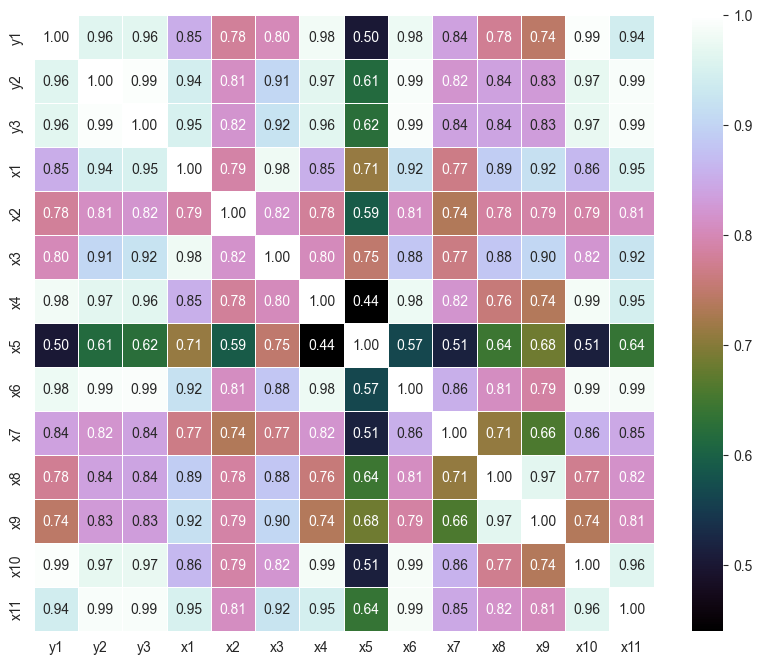

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(data.corr(), annot=True, fmt=".2f", linewidth=.5, cmap='magma')magma
sns.heatmap(data.corr(), annot=True, fmt=".2f", linewidth=.5, cmap='cubehelix')

<Axes: >

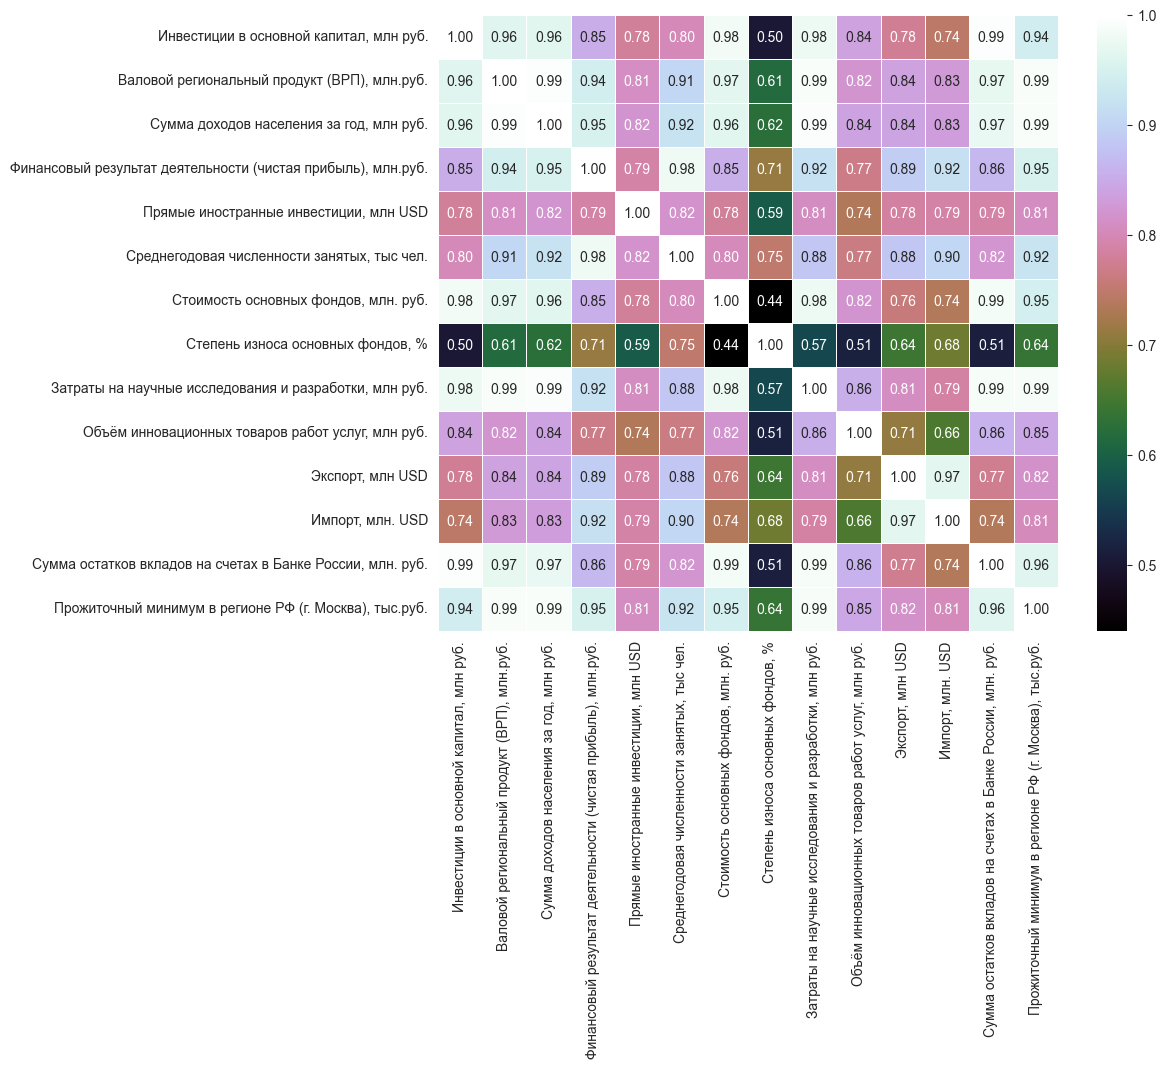

In [67]:
un_data = data.copy()
un_data.columns = ['Инвестиции в основной капитал, млн руб.', 'Валовой региональный продукт (ВРП), млн.руб.',
                   'Сумма доходов населения за год, млн руб.',
                   'Финансовый результат деятельности (чистая прибыль), млн.руб.',
                   'Прямые иностранные инвестиции, млн USD',
                   'Среднегодовая численности занятых, тыс чел.', 'Стоимость основных фондов, млн. руб.',
                   'Степень износа основных фондов, %',
                   'Затраты на научные исследования и разработки, млн руб.',
                   'Объём инновационных товаров работ услуг, млн руб.', 'Экспорт, млн USD',
                   'Импорт, млн. USD', 'Сумма остатков вкладов на счетах в Банке России, млн. руб.',
                   'Прожиточный минимум в регионе РФ (г. Москва), тыс.руб.']

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(un_data.corr(), annot=True, fmt=".2f", linewidth=.5, cmap='cubehelix')

# Исследование данных на наличие выбросов

Нахождение выбросов - это один из методов анализа данных, который используется для выявления аномальных значений в наборе данных. Выбросы могут возникать из-за ошибок в данных, случайных вариаций или из-за наличия редких, но реальных экстремальных значений.

Существует несколько методов нахождения выбросов, в том числе метод Z-оценки и метод межквартильного размаха (IQR).

In [68]:
# Смотрим размерность данных
data.shape

(25, 14)

Изначально мы имели набор данных, состоящий из 25 значений, охватывающих период с 1998 по 2022 год. На это нам указывает размерность данных (25, 14).

**Z-оценка**

Метод Z-оценки основан на расчете Z-оценки для каждого значения в наборе данных и проверке, насколько далеко каждое значение от среднего значения. Значения, которые находятся на расстоянии больше чем три стандартных отклонения от среднего, могут быть считаны выбросами.

In [69]:
z = np.abs(stats.zscore(data))
data_clean = data[(z < 3).all(axis=1)]
data_clean.shape

(25, 14)

**Межквартильный размах (IQR)**

Метод межквартильного размаха (IQR) основан на вычислении интерквартильного размаха - разницы между 75-перцентилью и 25-перцентилем. Затем определяется верхняя и нижняя границы выбросов, которые определяются как 1,5 межквартильных размаха за пределами верхнего и нижнего квартилей.

In [70]:
# Находим Первый квартиль (Q1) и Третий квартиль (Q3) и рассчитываем межквартильный размах
Q1 = data.quantile(q=.25)
Q3 = data.quantile(q=.75)
IQR = data.apply(stats.iqr)

# Оставляем только те значения, которые больше нижней границы и меньше верхней границы.
data_clean = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_clean.shape  # без 20,21,22 годов

(25, 14)

В результате проверки на наличие выбросов мы получили исходный набор данных, состоящий из 25 значений, охватывающих период с 1998 по 2022 год. На это нам указывает размерность данных (25, 14). Это говорит нам о том что выбросов в данных найденно не было.

In [71]:
# Заменяем исходный набор данных на очищенный
data = data_clean

# Построение модели линейной регрессии

Линейная регрессия - это метод анализа данных, который используется для описания и прогнозирования линейной связи между зависимой и одной или несколькими независимыми переменными. Он часто используется в статистическом анализе данных для построения математической модели, которая может быть использована для прогнозирования значений зависимой переменной на основе значений независимых переменных.

Для построения модели линейной регрессии необходимо иметь набор данных, который состоит из пар значений зависимой и независимой переменных. Затем на основе этих данных проводится анализ, который позволяет оценить параметры модели - коэффициенты наклона и пересечения. Эти параметры могут быть использованы для построения уравнения линейной регрессии.

Для оценки качества модели линейной регрессии используются различные статистические показатели, такие как коэффициент детерминации (R-квадрат) или корреляционный коэффициент. Они позволяют оценить, насколько хорошо модель соответствует данным и насколько точно она может использоваться для прогнозирования значений зависимой переменной.

Важно понимать, что линейная регрессия является моделью, которая описывает только линейные отношения между переменными. Если связь между переменными не является линейной, то модель линейной регрессии может оказаться неэффективной и требовать использования других методов анализа данных.

In [72]:
class CustomLinearRegression:
    def __init__(self, y, x, model_type=OLS):
        self.model_type = model_type
        self.y = y
        self.x = x
        # self.x = sm.add_constant(x)
        self.model = self.model_type(self.y, self.x).fit()
        # self.model = sm.OLS(self.y, self.x).fit_regularized(alpha=1., L1_wt=0.5, refit=True)

    def get_coefficients(self):
        return self.model.params

    def summary(self):
        print(self.model.summary())

    def pre(self):
        return self.model.predict(self.x)

    def F(self):
        return self.model.fvalue

    def p(self):
        return self.model.f_pvalue

    def current_p(self, i):
        return self.model.pvalues[i]

    def R2(self):
        return self.model.rsquared

    def R2_adj(self):
        return self.model.rsquared_adj

    def t(self):
        return self.model.tvalues

    def forward_selection(self):
        xi = []
        stop = False
        x_new = []  # список переменных, которые будут включены в модель
        x_len = len(self.x.columns) - 1  # количество столбцов в датафрейме
        x_test = []
        for n in range(x_len):
            F_max = 0  # максимальное значение F
            p_max = 0  # максимальное значение p
            F_max_i = 0
            F_max_x = ''
            if not stop:
                for i in range(x_len):
                    if i not in xi:
                        x_test = x_new.copy()
                        x_test.append(self.x.columns[i])
                        F = CustomLinearRegression(self.y, self.x.loc[:, x_test]).F()
                        print(f"'x{i + 1}',", F)
                        if F > F_max:
                            F_max = F
                            F_max_i = i
                            F_max_x = f"x{i + 1}"
                x_new.append(F_max_x)
                xi.append(F_max_i)
                print(x_new)
                for j in range(len(x_new)):
                    p = CustomLinearRegression(self.y, self.x.loc[:, x_new]).current_p(j)
                    if p > 0.05:
                        stop = True
                        print(f'P-value: {p}')
                        break
        CustomLinearRegression(self.y, self.x.loc[:, x_new[:-1]]).summary()

    def backward_elimination(self, p=0.05, start=0):
        regression = self.model_type(self.y, self.x).fit()
        futures_num = len(self.x.columns)
        for i in range(futures_num):
            # self.x = sm.add_constant(self.x)
            regression = self.model_type(self.y, self.x).fit()
            max_p = max(regression.pvalues.values[start:])
            if max_p > p:
                for j in range(0, futures_num - i):
                    if regression.pvalues[j] == max_p:
                        self.x = self.x.drop(self.x.columns[[j]], axis=1)
        print(regression.summary())

    def custom_feature_selection(x, y, model=LinearRegression(), selection_method=RFE):
        result_list = list()
        result = selection_method(model).fit(x, y)
        for i, feature in enumerate(result.get_support()):
            if feature:
                result_list.append(f'x{i + 1}')
        CustomLinearRegression(y, x[result_list]).summary()

    def correlation_map(self):
        return sns.heatmap(self.x.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='magma')

# Отбор переменных для модели линейной регрессии

Отбор переменных для модели линейной регрессии - это процесс выбора наиболее важных и значимых независимых переменных, которые будут использоваться в модели для прогнозирования зависимой переменной. Это важный шаг в построении модели, так как использование неподходящих переменных может привести к низкой точности прогнозов и низкому качеству модели.

Существует несколько методов отбора переменных для модели линейной регрессии, включая:

- Метод пошагового отбора переменных - это метод, который включает или исключает независимые переменные в модель пошагово на основе их значимости. На каждом шаге происходит выбор переменной, которая наиболее улучшает качество модели.

- Метод отбора на основе значимости - этот метод основан на анализе значимости каждой независимой переменной с помощью статистических тестов, таких как t-тест или F-тест. Переменные с низким уровнем значимости исключаются из модели.

- Метод регуляризации - это метод, который добавляет штрафы за большие значения коэффициентов в модель. Он позволяет автоматически отбирать переменные, которые наиболее важны для модели, и уменьшает вероятность переобучения.

- Метод отбора на основе информационных критериев - этот метод основан на использовании различных информационных критериев, таких как AIC (критерий Акаике) и BIC (критерий Шварца), чтобы выбрать модель с наименьшей ошибкой.

Выбор метода отбора переменных зависит от конкретной задачи и объема доступных данных. Важно также учитывать возможную мультиколлинеарность между независимыми переменными, что может привести к искажению результатов. Поэтому важно проводить анализ и выбор переменных внимательно и осознанно.

Сначала посмотрим на данные, которые мы будем использовать для построения модели линейной регрессии.

In [73]:
data.head()

,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,0.000000,0.000000,0.000000,0.000000,0.000104,0.000000,0.000000,0.171866,0.000000,0.001085,0.002163,0.000000,0.000000,0.000000
1,0.006149,0.016090,0.011181,0.028630,0.000000,0.050060,0.000802,0.195276,0.010867,0.000599,0.005918,0.009122,0.001756,0.023930
2,0.013222,0.036457,0.023958,0.057260,0.004312,0.100574,0.003081,0.118335,0.022750,0.001086,0.008692,0.019859,0.004676,0.045694
3,0.016599,0.045725,0.055902,0.085890,0.002316,0.153123,0.008333,0.000000,0.035862,0.000219,0.000000,0.046669,0.007243,0.057320
4,0.025519,0.063165,0.083854,0.114519,0.004531,0.217142,0.013826,0.324371,0.050506,0.000408,0.004786,0.055851,0.011277,0.088019


Мы имеем дело с набором данных, содержащим 11 независимых переменных и 3 зависимых переменных. Переменные x1-x11 являются независимыми переменными, а переменные y1-y3 являются зависимыми переменными. Всего у нас 25 наблюдений. Разделим данные на независимые и зависимые переменные.

### Разделение данных на зависимые и независимые переменные

Зависимые переменные - это переменные, значения которых мы хотим предсказать. В нашем случае это переменные y1, y2 и y3.

In [74]:
y = data[['y1', 'y2', 'y3']]
y1 = y['y1']
y2 = y['y2']
y3 = y['y3']

Независимые переменные - это переменные, значения которых мы используем для прогнозирования зависимых переменных. В нашем случае это переменные x1-x11.

In [75]:
X = data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']]
x1 = X['x1']
x2 = X['x2']
x3 = X['x3']
x4 = X['x4']
x5 = X['x5']
x6 = X['x6']
x7 = X['x7']
x8 = X['x8']
x9 = X['x9']
x10 = X['x10']
x11 = X['x11']

## Оценка предварительно составленных систем уравнений

Всего у нас три системы уравнений, которые мы можем использовать для прогнозирования зависимых переменных
- Система независимых уравнений;
- Система рекурсивных уравнений;
- Система одновременных уравнений.

#### Система независимых уравнений
$$
\begin{cases}
y_1 = a_1 + b_{11}x_{1} + b_{12}x_{2} + \epsilon \\
y_2 = a_2 + b_{21}x_{1} + b_{22}x_{2} + b_{23}x_{3} + b_{24}x_{4} + b_{25}x_{5} + b_{26}x_{6} + b_{27}x_{7} + b_{28}x_{8} + b_{29}x_{9} + \epsilon \\
y_3 = a_3 + b_{31}x_{1} + b_{32}x_{2} + b_{33}x_{3} + b_{34}x_{4} + b_{35}x_{5} + b_{36}x_{6} + b_{37}x_{7} + b_{38}x_{8} + b_{39}x_{9} + b_{310}x_{10} + b_{311}x_{11} + \epsilon \\
\end{cases}
$$

#### Система рекурсивных уравнений
$$
\begin{cases}
y_1 = a_1 + b_{11}x_{1} + b_{12}x_{2} + \epsilon \\
y_2 = a_2 + a_{21}y_1 + b_{21}x_{3} + b_{22}x_{4} + b_{23}x_{5} + b_{24}x_{6} + b_{25}x_{7} + b_{26}x_{8} + b_{27}x_{9} + \epsilon \\
y_3 = a_3 + a_{31}y_1 + a_{32}y_2 + b_{31}x_{11} + \epsilon \\
\end{cases}
$$

#### Система одновременных уравнений
$$
\begin{cases}
y_1 = a_1 + b_{11}x_{1} + b_{12}x_{2} + \epsilon \\
y_2 = a_2 + a_{21}y_1 + b_{23}x_{3} + b_{24}x_{4} + b_{25}x_{5} + b_{26}x_{6} + b_{27}x_{7} + b_{28}x_{8} + b_{29}x_{9} + \epsilon \\
y_3 = a_3 + a_{31}y_1 + b_{310}x_{10} + b_{311}x_{11} + \epsilon \\
\end{cases}
$$

## Система независимых уравнений

$$
\begin{cases}
y_1 = a_1 + b_{11}x_{1} + b_{12}x_{2} + \epsilon \\
y_2 = a_2 + b_{21}x_{1} + b_{22}x_{2} + b_{23}x_{3} + b_{24}x_{4} + b_{25}x_{5} + b_{26}x_{6} + b_{27}x_{7} + b_{28}x_{8} + b_{29}x_{9} + \epsilon \\
y_3 = a_3 + b_{31}x_{1} + b_{32}x_{2} + b_{33}x_{3} + b_{34}x_{4} + b_{35}x_{5} + b_{36}x_{6} + b_{37}x_{7} + b_{38}x_{8} + b_{39}x_{9} + b_{310}x_{10} + b_{311}x_{11} + \epsilon \\
\end{cases}
$$

### Первое уравнение

$$y_1 = a_1 + b_{11}x_{1} + b_{12}x_{2} + \epsilon $$

#### Исходная система уравнений

In [76]:
fn1_nez = pd.concat([x1, x2], axis=1)
CustomLinearRegression(y1, fn1_nez).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y1   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              78.77
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    5.12e-11
Time:                        18:52:50   Log-Likelihood:                          13.179
No. Observations:                  25   AIC:                                     -22.36
Df Residuals:                      23   BIC:                                     -19.92
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Исходная система уравнений с выбором признаков методом обратного исключения

In [77]:
CustomLinearRegression(y1, fn1_nez).backward_elimination()

                                 OLS Regression Results                                
Dep. Variable:                     y1   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              78.77
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    5.12e-11
Time:                        18:52:50   Log-Likelihood:                          13.179
No. Observations:                  25   AIC:                                     -22.36
Df Residuals:                      23   BIC:                                     -19.92
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Конечная система уравнений и веса

In [78]:
CustomLinearRegression(y1, pd.concat([x1, x2], axis=1)).get_coefficients()

x1    0.373607
x2    0.315691
dtype: float64

$$\hat y_1 = -0.108983 + 0.0696987x_{1}$$

### Второе уравнение

$$y_2 = a_2 + b_{21}x_{1} + b_{22}x_{2} + b_{23}x_{3} + b_{24}x_{4} + b_{25}x_{5} + b_{26}x_{6} + b_{27}x_{7} + b_{28}x_{8} + b_{29}x_{9} + \epsilon$$

#### Исходная система уравнений

In [79]:
fn2_nez = pd.concat([x1, x2, x3, x4, x5, x6, x7, x8, x9], axis=1)
CustomLinearRegression(y2, fn2_nez).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              812.1
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    1.50e-19
Time:                        18:52:52   Log-Likelihood:                          57.516
No. Observations:                  25   AIC:                                     -97.03
Df Residuals:                      16   BIC:                                     -86.06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Исходная система уравнений с выбором признаков методом обратного исключения

In [80]:
CustomLinearRegression(y2, fn2_nez).backward_elimination()

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              1733.
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    3.99e-26
Time:                        18:52:53   Log-Likelihood:                          53.463
No. Observations:                  25   AIC:                                     -98.93
Df Residuals:                      21   BIC:                                     -94.05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Конечная система уравнений и веса

In [81]:
CustomLinearRegression(y2, pd.concat([x1, x6, x7], axis=1)).get_coefficients()

x1    0.193072
x6    0.891795
x7   -0.080009
dtype: float64

$$\hat y_2 = 0.006827 - 0.246224x_{1} + 1.155669x_{6} - 0.015849x_{7}$$

$$\hat y_2 = - 0.246224x_{1} + 1.155669x_{6} - 0.015849x_{7}$$


### Третье уравнение

$$y_3 = a_3 + b_{31}x_{1} + b_{32}x_{2} + b_{33}x_{3} + b_{34}x_{4} + b_{35}x_{5} + b_{36}x_{6} + b_{37}x_{7} + b_{38}x_{8} + b_{39}x_{9} + b_{310}x_{10} + b_{311}x_{11} + \epsilon$$

#### Исходная система уравнений

In [82]:
fn3_nez = pd.concat([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11], axis=1)
CustomLinearRegression(y3, fn3_nez).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y3   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              1381.
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    2.90e-19
Time:                        18:52:55   Log-Likelihood:                          68.559
No. Observations:                  25   AIC:                                     -115.1
Df Residuals:                      14   BIC:                                     -101.7
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Исходная система уравнений с выбором признаков методом обратного исключения

In [83]:
CustomLinearRegression(y3, fn3_nez).backward_elimination()

                                 OLS Regression Results                                
Dep. Variable:                     y3   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              3761.
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    1.19e-29
Time:                        18:52:56   Log-Likelihood:                          63.378
No. Observations:                  25   AIC:                                     -118.8
Df Residuals:                      21   BIC:                                     -113.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Конечная система уравнений и веса

In [84]:
CustomLinearRegression(y3, pd.concat([x1, x10], axis=1)).get_coefficients()

x1     0.420865
x10    0.597156
dtype: float64

$$\hat y_3 = 0.018786 - 0.026029x_{1} + 0.979811x_{10}$$

In [85]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(X)
#
# print(pca.explained_variance_ratio_)
#
# print(pca.singular_values_)

## Система рекурсивных уравнений

$$
\begin{cases}
y_1 = a_1 + b_{11}x_{1} + b_{12}x_{2} + \epsilon \\
y_2 = a_2 + a_{21}y_1 + b_{21}x_{3} + b_{22}x_{4} + b_{23}x_{5} + b_{24}x_{6} + b_{25}x_{7} + b_{26}x_{8} + b_{27}x_{9} + \epsilon \\
y_3 = a_3 + a_{31}y_1 + a_{32}y_2 + b_{31}x_{11} + \epsilon \\
\end{cases}
$$

### Первое уравнение

$$y_1 = a_1 + b_{11}x_{1} + b_{12}x_{2} + \epsilon$$

#### Исходная система уравнений

In [86]:
fn1_rec = pd.concat([x1, x2], axis=1)
# CustomLinearRegression(y1, fn1_rec).summary()

#### Исходная система уравнений с выбором признаков методом обратного исключения

In [87]:
# CustomLinearRegression(y1, fn1_rec).backward_elimination()

#### Конечная система уравнений и веса

In [88]:
# CustomLinearRegression(y1, pd.concat([y1, y2], axis=1)).get_coefficients()

### Второе уравнение

$$y_2 = a_2 + a_{21}y_1 + b_{21}x_{3} + b_{22}x_{4} + b_{23}x_{5} + b_{24}x_{6} + b_{25}x_{7} + b_{26}x_{8} + b_{27}x_{9} + \epsilon$$

#### Исходная система уравнений

In [89]:
fn2_rec = pd.concat([y1, x1, x2, x3, x4, x5, x6, x7, x8, x9], axis=1)
CustomLinearRegression(y2, fn2_rec).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              704.8
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    3.62e-18
Time:                        18:53:02   Log-Likelihood:                          57.867
No. Observations:                  25   AIC:                                     -95.73
Df Residuals:                      15   BIC:                                     -83.55
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Исходная система уравнений с выбором признаков методом обратного исключения

In [90]:
CustomLinearRegression(y2, fn2_rec).backward_elimination(start=2)

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              1857.
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    1.35e-26
Time:                        18:53:03   Log-Likelihood:                          50.163
No. Observations:                  25   AIC:                                     -94.33
Df Residuals:                      22   BIC:                                     -90.67
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Конечная система уравнений и веса

In [91]:
CustomLinearRegression(y1, pd.concat([y1, x1, x6, x7], axis=1)).get_coefficients()

y1    1.000000e+00
x1   -1.578598e-16
x6    4.440892e-16
x7    1.942890e-16
dtype: float64

### Третье уравнение

$$y_3 = a_3 + a_{31}y_1 + a_{32}y_2 + b_{31}x_{11} + \epsilon$$

#### Исходная система уравнений

In [92]:
fn3_rec = pd.concat([y1, y2, x11], axis=1)
CustomLinearRegression(y3, fn3_rec).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y3   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              2141.
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    2.83e-27
Time:                        18:53:05   Log-Likelihood:                          52.182
No. Observations:                  25   AIC:                                     -98.36
Df Residuals:                      22   BIC:                                     -94.71
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Исходная система уравнений с выбором признаков методом обратного исключения

In [93]:
CustomLinearRegression(y3, fn3_rec).backward_elimination()

                                 OLS Regression Results                                
Dep. Variable:                     y3   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              5866.
Date:                Sat, 15 Apr 2023   Prob (F-statistic):                    3.38e-30
Time:                        18:53:06   Log-Likelihood:                          49.969
No. Observations:                  25   AIC:                                     -97.94
Df Residuals:                      24   BIC:                                     -96.72
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Конечная система уравнений и веса

In [94]:
CustomLinearRegression(y3, pd.concat([y2], axis=1)).get_coefficients()

y2    0.988215
dtype: float64